In [1]:
!pip install ctgan
!pip install be_great
!pip install ucimlrepo
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 27.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline
from collections import Counter

import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,average_precision_score,roc_auc_score,precision_score,confusion_matrix,precision_recall_fscore_support as pfscore
from sklearn import metrics
from sklearn.metrics import average_precision_score

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

from ctgan import CTGAN
from ctgan import load_demo

from be_great import GReaT

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Adult data set

In [4]:
adult_df = load_demo()
adult_df['target'] =  adult_df['income'].apply(lambda x: 1 if x == '>50K' else 0)
adult_df = adult_df.drop('income', axis=1)
# Names of the columns that are discrete
discrete_columns = [
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native-country'
]
adult_df[discrete_columns] = adult_df[discrete_columns].astype("category")
adult_df['target'] = adult_df['target'].astype('int')
predictors = [i for i in adult_df.columns if i != 'target']
adult_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [5]:
train, test = train_test_split(adult_df, test_size=0.2, random_state=423,stratify = adult_df['target'])
n_diff = Counter(train['target'])[0] - Counter(train['target'])[1]

### postive class
pos_df = train[train['target']==1].copy()
neg_df = train[train['target']==0].copy()

CTGAN

In [7]:
# ctgan = CTGAN(epochs=10)
# ctgan.fit(pos_df, discrete_columns)
# pos_ctgan = ctgan.sample(pos_df.shape[0])
# ctgan.fit(neg_df, discrete_columns)
# neg_ctgan = ctgan.sample(neg_df.shape[0])
# train_ctgan = pd.concat([pos_ctgan, neg_ctgan])

# Create synthetic
ctgan = CTGAN(epochs=10)
ctgan.fit(pos_df, discrete_columns)
ctgan_data = ctgan.sample(n_diff)
train_ctgan = pd.concat([train, ctgan_data])
Counter(train_ctgan['target'])

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Counter({0: 19775, 1: 19775})

GreaT synthetic data

In [ ]:
g_model = GReaT(llm='distilgpt2', batch_size=32, epochs=25)
g_model.fit(pos_df)
pos_great = g_model.sample(n_samples=pos_df.shape[0])
g_model.fit(neg_df)
neg_great = g_model.sample(n_samples=neg_df.shape[0])
train_great = pd.concat([pos_great, neg_great])
train_great.to_csv('train_great_adult_full.csv',index=False)

# Counter(train_great['target'])
# train_great[discrete_columns] = train_great[discrete_columns].astype("category")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.819300
1000,0.646400
1500,0.626700
2000,0.617800
2500,0.612300
3000,0.608400
3500,0.605300
4000,0.602300
4500,0.600500


  0%|          | 0/6273 [00:00<?, ?it/s]The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
6285it [03:39, 28.59it/s]


Step,Training Loss
500,0.639400
1000,0.630800
1500,0.625700
2000,0.622600
2500,0.621200
3000,0.619400
3500,0.618400
4000,0.616700
4500,0.615300
5000,0.614800


KeyboardInterrupt: 

In [ ]:
# g_model = GReaT(llm='distilgpt2', batch_size=32, epochs=25)
# g_model.fit(pos_df)
# great_data = g_model.sample(n_samples=n_diff)
great_data.to_csv('train_great_adult.csv',index=False)
# train_great = pd.concat([train, great_data])
# Counter(train_great['target'])
# train_great[discrete_columns] = train_great[discrete_columns].astype("category")

SMOTE

In [ ]:
smote_up_rate = 1
#under = RandomUnderSampler(sampling_strategy = random_down_rate)
over = SMOTENC(categorical_features = 'auto',random_state = 42,sampling_strategy = smote_up_rate)
#steps = [('u', under),('o', over)]
steps = [('o', over)]
pipeline = Pipeline(steps=steps)
X_smote, y_smote = pipeline.fit_resample(train[predictors], train['target'])
Counter(y_smote)

Counter({0: 19775, 1: 19775})

In [12]:
# Define the objective function for Hyperopt
def objective(params):
    # train_data = lgb.Dataset(X_train, label=y_train.astype(int))
    # test_data = lgb.Dataset(X_test, label=y_test.astype(int))
    if 'max_depth' in params: params['max_depth']=int(params['max_depth'])
    if 'min_child_weight' in params: params['min_child_weight']=int(params['min_child_weight'])
    if 'max_delta_step' in params: params['max_delta_step']=int(params['max_delta_step'])
    estimator = LGBMClassifier(objective='binary',
                            random_state=314,
                            metric = 'average_precision',
                            verbose = -1)
    model = estimator.set_params(**params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    precision = average_precision_score(y_test, y_pred)

    return {'loss': -precision, 'status': STATUS_OK}

def lgbm_train(model_name):
  print(model_name)
# Define the search space for hyperparameters
  space = {
     'num_leaves': scope.int(hp.quniform('num_leaves', 31, 127, 1)), # Explore values between 31 and 127
    'max_depth': scope.int(hp.quniform('max_depth', 3, 10, 1)),   # Explore values between 3 and 10
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),  # Explore values in logarithmic scale
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1), # Explore values between 1 and 10
    'subsample': hp.uniform('subsample', 0.7, 1.0),            # Explore values between 0.7 and 1.0
    'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1.0),   # Explore values between 0.7 and 1.0
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 500, 50)), # Explore values between 100 and 500
    'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-8), np.log(1.0)),   # Explore values in logarithmic scale
    'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-8), np.log(1.0))    # Explore values in logarithmic scale
}

# Run Hyperopt optimization
  trials = Trials()
  best = fmin(fn=objective,
              space=space,
              algo=tpe.suggest,
              max_evals=50,  # Adjust as needed
              trials=trials)

# Print the best hyperparameters
  print("Best hyperparameters:", best)

  model = LGBMClassifier(objective = 'binary',
                        random_state=314,
                        metric='average_precision')

  if 'n_estimators' in best: best['n_estimators']=int(best['n_estimators'])
  if 'max_depth' in best: best['max_depth']=int(best['max_depth'])
  if 'num_leaves' in best: best['num_leaves']=int(best['num_leaves'])

  model.set_params(**best)
  model.fit(X_train, y_train)
                #   early_stopping_rounds = 10,
               #  eval_metric = 'average_precision',
                #   eval_set = [(X_test,y_test)],
                #   eval_names = ['valid'],
                #   verbose = 50,


  y_prob = model.predict_proba(X_test)[:,1]

    # score
  model_ap = average_precision_score(y_test, y_prob)
  model_auc = roc_auc_score(y_test, y_prob)
  print(f"test set pr-auc: {model_ap}")

  return(model_ap,model_auc,y_prob)



In [ ]:
X_train = train[predictors]
y_train = train['target']
X_test = test[predictors]
y_test = test['target']

In [ ]:
ap_base,auc_base,y_base = lgbm_train('baseline')

baseline
100%|██████████| 50/50 [00:37<00:00,  1.34trial/s, best loss: -0.6159289242266146]
Best hyperparameters: {'colsample_bytree': 0.7324694184347287, 'learning_rate': 0.06295031421751963, 'max_depth': 5.0, 'min_child_weight': 3.0, 'n_estimators': 350.0, 'num_leaves': 40.0, 'reg_alpha': 5.682691366367991e-05, 'reg_lambda': 8.134071826777565e-08, 'subsample': 0.9495615262943929}
test set pr-auc: 0.8372997558026292


In [ ]:
X_train = train_ctgan[predictors]
y_train = train_ctgan['target']
ap_ctgan,auc_ctgan,y_ctgan = lgbm_train('ctgan')

ctgan
100%|██████████| 50/50 [00:29<00:00,  1.70trial/s, best loss: -0.4249966424713277]
Best hyperparameters: {'colsample_bytree': 0.9706569129387095, 'learning_rate': 0.04166684970944682, 'max_depth': 6.0, 'min_child_weight': 8.0, 'n_estimators': 350.0, 'num_leaves': 76.0, 'reg_alpha': 0.25295783952173706, 'reg_lambda': 0.0006677396926760951, 'subsample': 0.7789956195457124}
test set pr-auc: 0.7407474356501835


In [ ]:
X_train = train_great[predictors]
y_train = train_great['target']
ap_great,auc_great,y_great = lgbm_train('great')

great
100%|██████████| 50/50 [00:25<00:00,  1.93trial/s, best loss: -0.5745085133602947]
Best hyperparameters: {'colsample_bytree': 0.9518240250571348, 'learning_rate': 0.06243761381247366, 'max_depth': 5.0, 'min_child_weight': 6.0, 'n_estimators': 450.0, 'num_leaves': 109.0, 'reg_alpha': 1.7996240515026684e-07, 'reg_lambda': 1.0620922867677226e-08, 'subsample': 0.7588356690077176}
test set pr-auc: 0.8221229221125343


In [ ]:
X_train = X_smote
y_train = y_smote
ap_smote,auc_smote,y_smote = lgbm_train('smote')

smote
100%|██████████| 50/50 [00:45<00:00,  1.10trial/s, best loss: -0.5905342399274098]
Best hyperparameters: {'colsample_bytree': 0.7805392921780411, 'learning_rate': 0.1600606560218137, 'max_depth': 6.0, 'min_child_weight': 6.0, 'n_estimators': 300.0, 'num_leaves': 36.0, 'reg_alpha': 0.00018856179399769267, 'reg_lambda': 0.48517144803545675, 'subsample': 0.9706371358831071}
test set pr-auc: 0.8215357931217402


In [10]:
def precison_recall_metrics(label,pred):
    fpr, tpr, thresh = metrics.roc_curve(label, pred)
    auc = np.round(metrics.roc_auc_score(label, pred),3)
    precision, recall, thresholds = metrics.precision_recall_curve(label, pred)
    average_precision = np.round(metrics.average_precision_score(label, pred),3)
    #prauc = np.round(metrics.auc(precision,recall),3)
    prauc = np.round(average_precision_score(label,pred),3)
    f1 = 2*precision*recall/(precision + recall)
    return fpr, tpr, thresholds, auc, precision,recall,f1,prauc

def perf_comp(score_df, model_name):

    #################################################################
    # input df : ['target','score1','score2','score3',...]
    # model name: model name
    #################################################################

    for i in [col for col in score_df.columns if col != 'applicationId']:
        score_df[i] = score_df[i].astype(float)
    score_df = score_df.dropna()
    n_comparison = score_df.shape[1] - 1
    print(f'number of models is {n_comparison}')
    d = {}
    perf_df = pd.DataFrame()

    fig, ax = plt.subplots(1, 2, figsize=(14,5))
    fig.tight_layout()
    for i in range(n_comparison):
        index = i + 1
        d[f"label{index}"] = score_df['target']
        d[f'score{index}' ] = score_df[f'score{index}']

        # precison_recall_metrics(d['label{0}'. ],d['score{0}'. ])
        d[f'fpr{index}' ], d[f'tpr{index}' ], d[f'thresh{index}'],d[f'auc{index}'],d[f'precision{index}'],d[f'recall{index}'],d[f'f1_{index}'],d[f'aucpr{index}'] = precison_recall_metrics(d[f'label{index}'],d[f'score{index}'])

         # plt.subplot(1, 2, 1)
        ax[0].plot(d[f'fpr{index}'],d[f'tpr{index}'],label=  f"{model_name[i]},auc="+ str(d[f'auc{index}']))
        ax[0].set_xlabel('FPR')
        ax[0].set_ylabel('TPR')
        ax[0].set_title('ROC Curve Comparison')
        ax[0].legend(loc=4)

        # plt.subplot(1, 2, 2)
        ax[1].plot(d[f'recall{index}'],d[f'precision{index}'],label= f"{model_name[i]},AUCPR ="+ str(d[f'aucpr{index}']))
        ax[1].set_xlabel('Recall')
        ax[1].set_ylabel('Precision')
        ax[1].set_title('Precision-Recall Curve Comparison')
        plt.legend(loc=0)

        # perf = perf_array(score_df,f'score{index}')
        # if index > 1:
        #     perf = perf.drop('actual_sending_rate',axis = 1)
        # perf = perf.add_suffix(f'_{model_name[i]}')
        # perf_df = pd.concat([perf_df,perf], axis = 1)

    plt.show()

    return(perf_df)


In [ ]:
y_test_df = y_test.to_frame()
y_test_df['score1'] = y_base
y_test_df['score2'] = y_ctgan
y_test_df['score3'] = y_great
y_test_df['score4'] = y_smote

number of models is 4


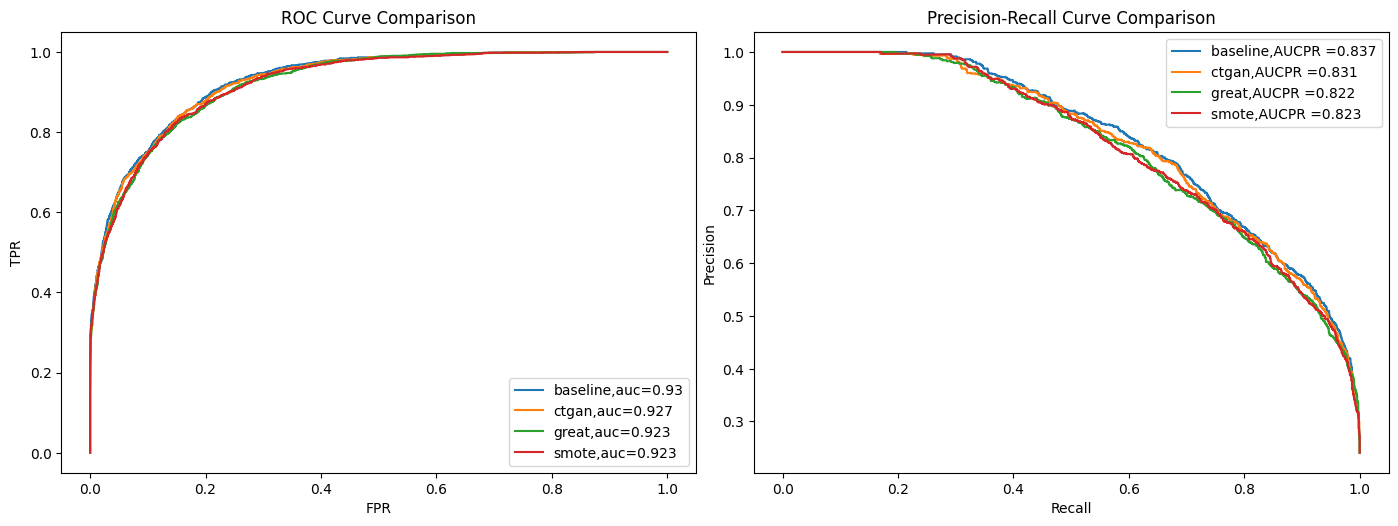

""


In [ ]:
perf_comp(y_test_df,['baseline','ctgan','great','smote'])

### Credit card default data

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
default_of_credit_card_clients = fetch_ucirepo(id=350)

# data (as pandas dataframes)
X = default_of_credit_card_clients.data.features
y = default_of_credit_card_clients.data.targets

# # metadata
# print(default_of_credit_card_clients.metadata)

# # variable information
# print(default_of_credit_card_clients.variables)

In [ ]:
credit_df = X.copy()
credit_df.columns = list(default_of_credit_card_clients.variables['description'][1:][:-1])
credit_df['target'] = y
credit_df['target'] = credit_df['target'].astype('int')
credit_df['target'].value_counts()
credit_df.head()

predictors = [i for i in credit_df.columns if i != 'target']
discrete_columns = ['SEX','EDUCATION','MARRIAGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']

credit_df[discrete_columns] = credit_df[discrete_columns].astype("category")

In [ ]:
train, test = train_test_split(credit_df, test_size=0.2, random_state=423,stratify = credit_df['target'])
n_diff = Counter(train['target'])[0] - Counter(train['target'])[1]

### postive class
pos_df = train[train['target']==1].copy()

ctgan = CTGAN(epochs=10)
ctgan.fit(pos_df, discrete_columns)

# Create synthetic data
ctgan_data = ctgan.sample(n_diff)
train_ctgan = pd.concat([train, ctgan_data])
Counter(train_ctgan['target'])

Counter({0: 18691, 1: 18691})

In [ ]:
g_model = GReaT(llm='distilgpt2', batch_size=32, epochs=30)
g_model.fit(pos_df)
great_data = g_model.sample(n_samples=n_diff,max_length=2000)
great_data.to_csv('train_great_credit.csv',index=False)
train_great = pd.concat([train, great_data])
Counter(train_great['target'])
train_great[discrete_columns] = train_great[discrete_columns].astype("category")



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.961600
1000,0.849500
1500,0.830900
2000,0.818900
2500,0.811700
3000,0.806300
3500,0.801900
4000,0.798600
4500,0.796200


  0%|          | 0/13382 [00:00<?, ?it/s]The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
13425it [03:48, 58.73it/s]


In [ ]:
smote_up_rate = 1
#under = RandomUnderSampler(sampling_strategy = random_down_rate)
over = SMOTENC(categorical_features = 'auto',random_state = 42,sampling_strategy = smote_up_rate)
#steps = [('u', under),('o', over)]
steps = [('o', over)]
pipeline = Pipeline(steps=steps)
X_smote, y_smote = pipeline.fit_resample(train[predictors], train['target'])
Counter(y_smote)

Counter({0: 18691, 1: 18691})

In [ ]:
X_train = train[predictors]
y_train = train['target']
X_test = test[predictors]
y_test = test['target']
Counter(y_test)

Counter({0: 4673, 1: 1327})

In [ ]:
ap_base,auc_base,y_base = lgbm_train('baseline')

baseline
100%|██████████| 50/50 [00:28<00:00,  1.76trial/s, best loss: -0.3794209716585929]
Best hyperparameters: {'colsample_bytree': 0.9949961835478737, 'learning_rate': 0.022789077284901316, 'max_depth': 3.0, 'min_child_weight': 3.0, 'n_estimators': 100.0, 'num_leaves': 116.0, 'reg_alpha': 0.0007010012832326448, 'reg_lambda': 0.056322124844625183, 'subsample': 0.9751687716080693}
test set pr-auc: 0.559235527702874


In [ ]:
X_train = train_ctgan[predictors]
y_train = train_ctgan['target']
ap_ctgan,auc_ctgan,y_ctgan = lgbm_train('ctgan')

ctgan
100%|██████████| 50/50 [00:35<00:00,  1.41trial/s, best loss: -0.39406933592458915]
Best hyperparameters: {'colsample_bytree': 0.768490264020952, 'learning_rate': 0.027042419594465107, 'max_depth': 8.0, 'min_child_weight': 9.0, 'n_estimators': 400.0, 'num_leaves': 93.0, 'reg_alpha': 0.014986359523468155, 'reg_lambda': 0.00040313125126542447, 'subsample': 0.9986174893702967}
test set pr-auc: 0.557923750674714


In [ ]:
X_train = train_great[predictors]
y_train = train_great['target']
ap_great,auc_great,y_great = lgbm_train('great')

great
100%|██████████| 50/50 [00:28<00:00,  1.75trial/s, best loss: -0.3943489301454637]
Best hyperparameters: {'colsample_bytree': 0.9579203793959886, 'learning_rate': 0.014052676067890894, 'max_depth': 9.0, 'min_child_weight': 4.0, 'n_estimators': 200.0, 'num_leaves': 89.0, 'reg_alpha': 0.0986531046226471, 'reg_lambda': 0.03271709920931874, 'subsample': 0.890846105385829}
test set pr-auc: 0.5766337003909873


In [ ]:
X_train = X_smote
y_train = y_smote
ap_smote,auc_smote,y_smote = lgbm_train('smote')

smote
100%|██████████| 50/50 [00:31<00:00,  1.57trial/s, best loss: -0.37941120246618754]
Best hyperparameters: {'colsample_bytree': 0.7779305556158931, 'learning_rate': 0.026886502458536972, 'max_depth': 3.0, 'min_child_weight': 10.0, 'n_estimators': 250.0, 'num_leaves': 102.0, 'reg_alpha': 3.5089919020152394e-05, 'reg_lambda': 1.6827382533705605e-07, 'subsample': 0.7263174263336074}
test set pr-auc: 0.55693896195674


number of models is 4


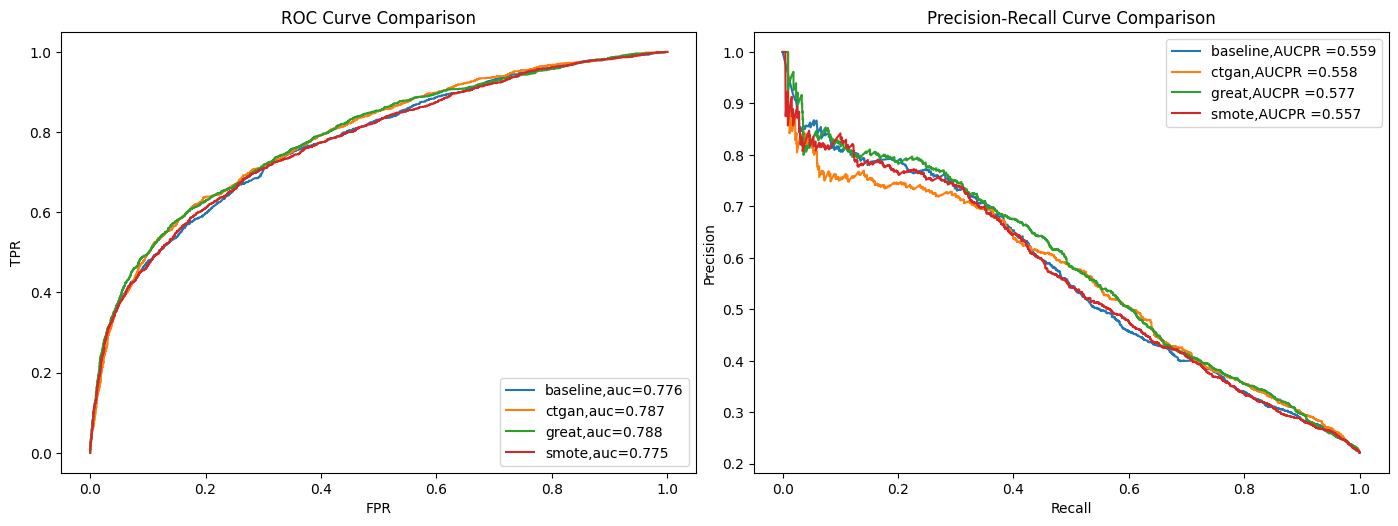

""


In [ ]:
y_test_df = y_test.to_frame()
y_test_df['score1'] = y_base
y_test_df['score2'] = y_ctgan
y_test_df['score3'] = y_great
y_test_df['score4'] = y_smote
perf_comp(y_test_df,['baseline','ctgan','great','smote'])

# Diabetes

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

# data (as pandas dataframes)
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

# metadata
print(cdc_diabetes_health_indicators.metadata)

# variable information
print(cdc_diabetes_health_indicators.variables)


{'uci_id': 891, 'name': 'CDC Diabetes Health Indicators', 'repository_url': 'https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators', 'data_url': 'https://archive.ics.uci.edu/static/public/891/data.csv', 'abstract': 'The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general along with their diagnosis of diabetes. The 35 features consist of some demographics, lab test results, and answers to survey questions for each patient. The target variable for classification is whether a patient has diabetes, is pre-diabetic, or healthy. ', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular', 'Multivariate'], 'num_instances': 253680, 'num_features': 21, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Sex', 'Age', 'Education Level', 'Income'], 'target_col': ['Diabetes_binary'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_

In [18]:
X.columns

Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

In [4]:
diabetes_df = X.copy()
diabetes_df['target'] = y
diabetes_df['target'] = diabetes_df['target'].astype('int')
diabetes_df['target'].value_counts()

predictors = [i for i in diabetes_df.columns if i != 'target']
discrete_columns = ['HighBP', 'HighChol', 'CholCheck','Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost','DiffWalk', 'Sex']

diabetes_df[discrete_columns] = diabetes_df[discrete_columns].astype("category")

In [5]:
train, test = train_test_split(diabetes_df, test_size=0.2, random_state=423,stratify = diabetes_df['target'])
n_diff = Counter(train['target'])[0] - Counter(train['target'])[1]

### postive class
pos_df = train[train['target']==1].copy()

ctgan = CTGAN(epochs=10)
ctgan.fit(pos_df, discrete_columns)

# Create synthetic data
ctgan_data = ctgan.sample(n_diff)
train_ctgan = pd.concat([train, ctgan_data])
Counter(train_ctgan['target'])

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Counter({0: 174667, 1: 174667})

In [6]:
g_model = GReaT(llm='distilgpt2', batch_size=32, epochs=10)
g_model.fit(pos_df)
great_data = g_model.sample(n_samples=n_diff,max_length = 2000)
great_data.to_csv('train_great_diabetes.csv',index=False)
train_great = pd.concat([train, great_data])
Counter(train_great['target'])
train_great[discrete_columns] = train_great[discrete_columns].astype("category")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.810700
1000,0.648300
1500,0.634100
2000,0.627800
2500,0.623500
3000,0.620400
3500,0.618700
4000,0.616500
4500,0.615800
5000,0.614100


  0%|          | 0/146390 [00:00<?, ?it/s]The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
146424it [23:04, 105.77it/s]


In [7]:
smote_up_rate = 1
#under = RandomUnderSampler(sampling_strategy = random_down_rate)
over = SMOTENC(categorical_features = 'auto',random_state = 42,sampling_strategy = smote_up_rate)
#steps = [('u', under),('o', over)]
steps = [('o', over)]
pipeline = Pipeline(steps=steps)
X_smote, y_smote = pipeline.fit_resample(train[predictors], train['target'])
Counter(y_smote)

Counter({0: 174667, 1: 174667})

In [8]:
X_train = train[predictors]
y_train = train['target']
X_test = test[predictors]
y_test = test['target']
Counter(y_test)

Counter({1: 7069, 0: 43667})

In [13]:
ap_base,auc_base,y_base = lgbm_train('baseline')

X_train = train_ctgan[predictors]
y_train = train_ctgan['target']
ap_ctgan,auc_ctgan,y_ctgan = lgbm_train('ctgan')

X_train = train_great[predictors]
y_train = train_great['target']
ap_great,auc_great,y_great = lgbm_train('great')

X_train = X_smote
y_train = y_smote
ap_smote,auc_smote,y_smote = lgbm_train('smote')

baseline
100%|██████████| 50/50 [01:27<00:00,  1.75s/trial, best loss: -0.21436472608903698]
Best hyperparameters: {'colsample_bytree': 0.9114328745702226, 'learning_rate': 0.15570654101013448, 'max_depth': 3.0, 'min_child_weight': 6.0, 'n_estimators': 200.0, 'num_leaves': 90.0, 'reg_alpha': 0.046559915473981334, 'reg_lambda': 7.118236698592775e-06, 'subsample': 0.9426787206982734}
test set pr-auc: 0.4380055380548145
ctgan
100%|██████████| 50/50 [02:45<00:00,  3.30s/trial, best loss: -0.2624100595274856]
Best hyperparameters: {'colsample_bytree': 0.8831281900166572, 'learning_rate': 0.01307479231877419, 'max_depth': 5.0, 'min_child_weight': 2.0, 'n_estimators': 300.0, 'num_leaves': 42.0, 'reg_alpha': 0.0005094904494550164, 'reg_lambda': 6.956329117710218e-05, 'subsample': 0.774686962724367}
test set pr-auc: 0.35619735319202017
great
100%|██████████| 50/50 [02:24<00:00,  2.89s/trial, best loss: -0.21520817158883565]
Best hyperparameters: {'colsample_bytree': 0.8974687270961368, 'learnin

number of models is 4


<ipython-input-10-039b6a00b8ed>:8: RuntimeWarning: invalid value encountered in divide
  f1 = 2*precision*recall/(precision + recall)


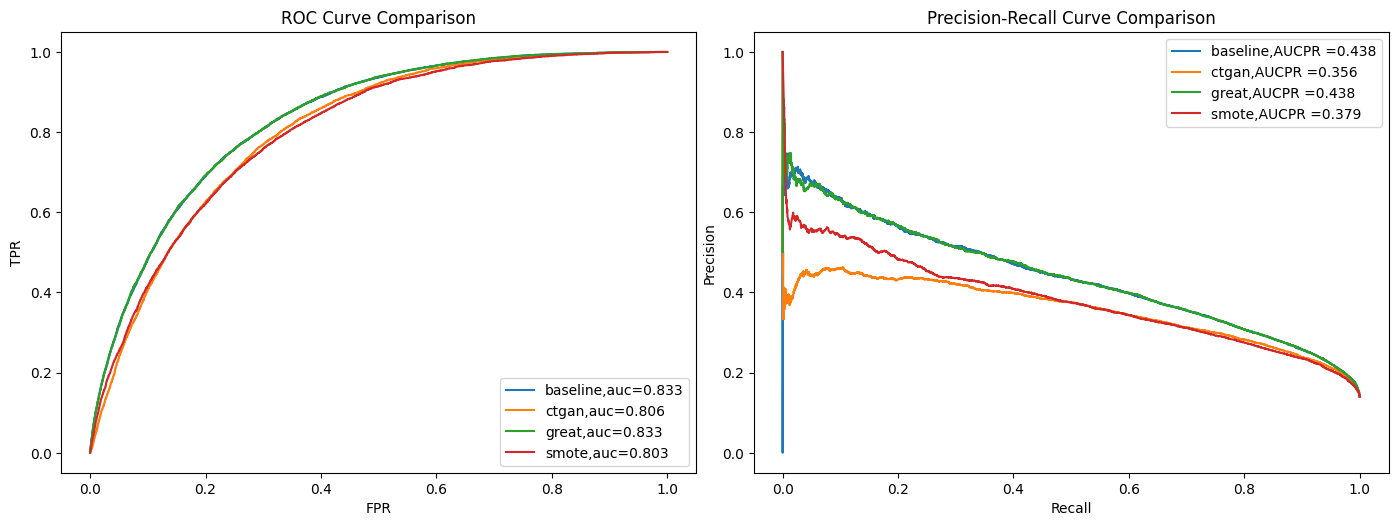

""


In [14]:
y_test_df = y_test.to_frame()
y_test_df['score1'] = y_base
y_test_df['score2'] = y_ctgan
y_test_df['score3'] = y_great
y_test_df['score4'] = y_smote
perf_comp(y_test_df,['baseline','ctgan','great','smote'])